In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py

import pandas as pd
import deepdish as dd
import os
import numpy as np
import pylab as plt
from glob import glob
from tqdm import tqdm
import seaborn as sns
from scipy.stats import ncx2
from pesummary.gw.conversions.spins import spin_angles
from GWFish.modules.detection import Network
from GWFish.modules.fishermatrix import compute_network_errors
import GWFish.modules as gwf_mods
import pathlib

## Get injection data SNRs

In [2]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
                             'CE4020ET123_CoBA10_SNR_5_pop_PLP_spin_prec_fref_5_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')
#inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
#                             'LHI_SNR_5_pop_PLP_spin_prec_fref_10_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')

In [3]:
def decode_bytes_recursive(val):
    if isinstance(val, bytes):
        return val.decode('utf-8')
    elif isinstance(val, np.ndarray):
        if val.dtype.kind == 'S':  # Byte string array
            return np.vectorize(lambda x: x.decode('utf-8'))(val)
        elif val.dtype.kind in {'O'}:
            return np.vectorize(decode_bytes_recursive)(val)
        else:
            return val
    elif isinstance(val, list):
        return [decode_bytes_recursive(v) for v in val]
    elif isinstance(val, dict):
        return {k: decode_bytes_recursive(v) for k, v in val.items()}
    return val

def load_h5_group(group):
    data = {}
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            data[key] = load_h5_group(item)
    return data

In [4]:
# Main loader
inj_data = {}
with h5py.File(inj_data_file, 'r') as f:
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            inj_data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            inj_data[key] = load_h5_group(item)

In [5]:
pd.DataFrame(inj_data['results'])

,PSD_C1,PSD_CE20,PSD_E1,PSD_E2,PSD_E3,SNR_C1,SNR_CE20,SNR_E1,SNR_E2,SNR_E3,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,26.890906,6.082231,11.573002,8.443707,4.183591,...,-0.151343,0.368443,0.336128,8.354979,6.641341,6.476252,14.996320,1.387950,2397.357958,1.893026e+09
1,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,30.923279,19.586402,8.216392,6.510056,6.628056,...,0.215131,-0.265249,0.083893,20.416446,8.293748,11.107885,28.710194,2.107388,40.357782,1.893026e+09
2,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,134.790289,58.389802,56.626102,57.878911,53.428096,...,-0.147023,-0.734618,0.526370,12.559317,8.447756,8.932054,21.007074,2.764603,139.074145,1.893027e+09
3,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,24.422831,10.987275,3.875804,5.155366,2.734553,...,0.428761,0.145118,-0.203761,10.836214,10.812505,9.423146,21.648719,1.366520,452.588451,1.893027e+09
4,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,22.438899,13.035350,10.440927,5.772831,5.237144,...,0.270313,0.499474,0.021336,17.554939,8.807417,10.699214,26.362356,2.334330,1334.041940,1.893028e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22755,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,60.338039,45.030861,20.728980,23.342237,24.073963,...,0.527377,-0.601355,-0.350036,7.922638,3.637087,4.604523,11.559725,2.523197,231.780097,1.924435e+09
22756,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,29.317528,17.671699,24.934851,22.595010,25.361612,...,0.010737,0.205612,-0.075798,30.715894,30.538703,26.662478,61.254596,1.005110,136.159327,1.924435e+09
22757,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,37.008786,17.526966,11.016267,14.723909,4.339288,...,0.029080,-0.001921,-0.040690,31.189314,24.274139,23.915993,55.463453,1.582021,2736.237313,1.924438e+09
22758,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,19.560080,16.292502,2.972777,5.018630,2.061012,...,0.105120,0.728601,-0.158751,11.143133,8.132996,8.267054,19.276129,1.515721,439.822230,1.924438e+09


### Get detected

In [6]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, 
                      method='network', return_detected_dict=False, 
                      snr_type='mf_from_opt'):
    if type(data_dict) == pd.core.frame.DataFrame:
        pass
    else:
        data_dict = pd.DataFrame(data_dict)
        
    if snr_type == 'opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR' in key and 'mf' not in key]
    elif snr_type == 'mf_from_opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf_from_opt' in key]
    elif snr_type == 'mf':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf' in key and 'from_opt' not in key]
    else:
        raise KeyError('Please choose snr_type from "opt" or "mf"')
    print(SNR_keys)
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        if snr_type == 'opt':
            dict_key = key.split('SNR_')[-1]
        elif snr_type == 'mf_from_opt':
            dict_key = key.split('SNR_mf_from_opt_')[-1]
        elif snr_type == 'mf':
            dict_key = key.split('SNR_mf_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

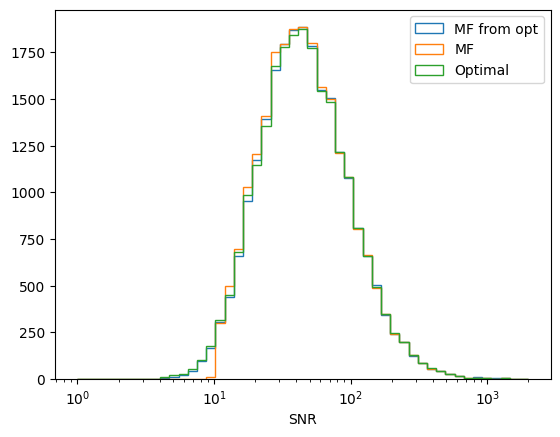

In [7]:
plt.hist(inj_data['results']['SNR_mf_from_opt_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF from opt');
plt.hist(inj_data['results']['SNR_mf_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF');
plt.hist(inj_data['results']['SNR_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='Optimal');
plt.xlabel('SNR')
plt.legend()
plt.xscale('log')

In [8]:
inj_data['detected_mf_from_opt'] = get_detected_SNRs(inj_data['results'], method='two-detector', 
                                                     snr_type='mf_from_opt', network_threshold=10)

['SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1', 'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network']


### Detected percentage

In [9]:
n_total = len(inj_data['results']['redshift'])
n_detected = len(inj_data['detected_mf_from_opt']['redshift'])

print('Total =', n_total)
print('detected =', n_detected, '=', round(n_detected*100/n_total, 1), '%')

Total = 22760
detected = 22268 = 97.8 %


### Choose n_events from detected as injection parameters

In [10]:
n_events = 5200
#n_events = len(inj_data['detected_mf_from_opt']['redshift'])
inj_data['selected_n_events'] = inj_data['detected_mf_from_opt'].sample(n_events, 
                                                                        random_state=123).reset_index().rename(columns={'index': 'old_index'})
#inj_data['selected_n_events'].insert(5, 'SNR_ET', np.sqrt(inj_data['selected_n_events']['SNR_E1']**2 + inj_data['selected_n_events']['SNR_E2']**2 + inj_data['selected_n_events']['SNR_E3']**2))
#inj_data['selected_n_events'] = inj_data['detected_mf'].iloc[:n_events]

Text(0.5, 0, 'z')

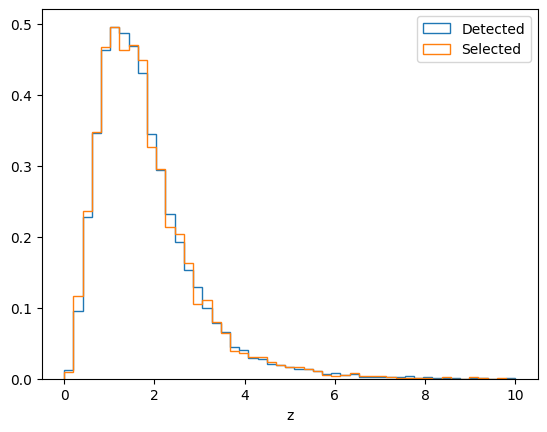

In [11]:
plt.hist(inj_data['detected_mf_from_opt']['redshift'], density=True, histtype=u'step', bins=np.linspace(0,10,50), 
         label='Detected')
plt.hist(inj_data['selected_n_events']['redshift'], density=True, histtype=u'step', 
         bins=np.linspace(0,10,50), label='Selected');
plt.legend()
plt.xlabel('z')

In [12]:
len(inj_data['selected_n_events']['redshift'])

5200

## FM analysis with GWFish

In [13]:
inj_data['selected_n_events'].keys()

Index(['old_index', 'PSD_C1', 'PSD_CE20', 'PSD_E1', 'PSD_E2', 'PSD_E3',
       'SNR_C1', 'SNR_CE20', 'SNR_E1', 'SNR_E2', 'SNR_E3', 'SNR_mf_C1',
       'SNR_mf_CE20', 'SNR_mf_E1', 'SNR_mf_E2', 'SNR_mf_E3',
       'SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1',
       'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network',
       'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1_in_plane',
       'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar',
       'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final',
       'f_lower', 'f_ref', 'inclination', 'mass1', 'mass2', 'mchirp', 'mtotal',
       'phi_12', 'phi_jl', 'polarization', 'q', 'ra', 'redshift', 'spin1_a',
       'spin1_azimuthal', 'spin1_polar', 'spin1x', 'spin1y', 'spin1z',
       'spin2_a', 'spin2_azimuthal', 'spin2_polar', 'spin2x', 'spin2y',
       'spin2z', 'srcmass1', 'srcmass2', 'srcmchirp', 'srcmtotal', 'theta_jn',
       'time_interval', 'trigger_time']

In [14]:
pycbc_to_pesummary_map = {
    'mchirp': 'chirp_mass',
    'q': 'mass_ratio',
    'distance': 'luminosity_distance',
    'theta_jn': 'theta_jn',
    'ra': 'ra',
    'dec': 'dec',
    'polarization': 'psi',
    'trigger_time': 'geocent_time',
    'coa_phase': 'phase',
    'spin1_a': 'a_1',
    'spin2_a': 'a_2',
    'spin1_polar': 'tilt_1',
    'spin2_polar':'tilt_2',
    'phi_12': 'phi_12',
    'phi_jl': 'phi_jl',
    'mass1': 'mass_1',
    'mass2': 'mass_2'
}
#gwfish_det_dict = {'L1':'L', 'H1':'H', 'I1':'IN'}

In [15]:
gwfish_input_data = {pycbc_to_pesummary_map[key]:inj_data['selected_n_events'][key] for key in pycbc_to_pesummary_map.keys() if key != 'q'}
gwfish_input_data = pd.DataFrame(gwfish_input_data)
gwfish_input_data['mass_ratio'] = 1/inj_data['selected_n_events']['q']

In [16]:
gwfish_input_data

,chirp_mass,luminosity_distance,theta_jn,ra,dec,psi,geocent_time,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,mass_1,mass_2,mass_ratio
0,25.046939,9166.725126,1.534143,3.138760,-0.845515,2.147303,1.911653e+09,1.102282,0.840703,0.979566,2.725209,2.051490,3.594697,3.642342,30.973154,26.754753,0.863805
1,11.883061,17311.366584,1.479538,4.723307,0.114258,0.645510,1.904448e+09,3.291709,0.124384,0.243726,2.148778,0.977003,3.020788,5.852060,21.179926,9.106981,0.429982
2,26.064813,16305.885620,2.173172,1.731818,-0.105157,0.766840,1.917591e+09,3.380692,0.983052,0.309748,0.987864,1.499000,2.047700,2.502986,38.263315,23.696141,0.619291
3,15.888994,10039.132841,2.048722,5.229659,-0.906319,2.593836,1.904023e+09,0.052499,0.540207,0.967556,1.369624,1.094461,3.821824,4.399860,20.175357,16.543879,0.820004
4,23.216875,24210.925912,2.805005,2.469360,0.071000,1.332727,1.905356e+09,2.612072,0.287847,0.342173,1.387429,1.565675,2.466039,1.416684,36.030240,20.075947,0.557197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,14.699844,3451.654509,0.865634,3.976166,0.027435,1.579564,1.901109e+09,2.815271,0.132478,0.742871,1.180068,1.673441,5.523689,5.295169,17.959833,15.887710,0.884625
5196,27.778154,16611.580196,1.701392,1.856913,-0.876371,0.462394,1.907678e+09,3.030719,0.799429,0.187221,1.226696,1.058240,1.604673,6.120929,33.729012,30.205040,0.895521
5197,30.257266,19613.879808,0.396028,3.366738,0.067322,1.374902,1.917494e+09,5.347785,0.349642,0.484078,0.941026,1.685182,3.692388,3.775931,35.064405,34.451777,0.982528
5198,13.656263,9803.660681,1.118596,0.079325,0.131497,0.561980,1.900084e+09,3.879665,0.757575,0.529270,0.970797,1.635355,3.097841,5.410196,20.260941,12.296352,0.606899


In [17]:
#detectors = ['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
detectors = ['CE1', 'CE2', 'ET']
matrix_file_names = f'CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_{n_events}_events_pop_from_XPHM_det10'
#matrix_file_names = f'LHI_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_{n_events}_events_pop_from_XPHM_det10'
matrix_file_names

'CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_5200_events_pop_from_XPHM_det10'

### Without parallelization

In [43]:
results = {'detected_idxs':[], 
           'netw_snrs':[], 
           'errors':[],
           'sky_locs':[]}
fisher_params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'phase', 'geocent_time', 'ra', 'dec', 'psi']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 5.), config=pathlib.Path('detectors.yaml'))
#for event_num in tqdm(range(len(inj_data['selected_n_events']))):
results['detected_idxs'], results['netw_snrs'], results['errors'], results['sky_locs'] = compute_network_errors(
    network=network, 
    parameter_values=gwfish_input_data,
    fisher_parameters=fisher_params, 
    f_ref=inj_data['selected_n_events']['f_ref'][0], 
    waveform_model='IMRPhenomXPHM',
    save_matrices=True,
    save_matrices_path=pathlib.Path(os.path.join(base_dir, 
                                                 'GWFish_analysis', 
                                                 'BBH',
                                                 'Fisher_matrices')),
    matrix_naming_postfix=matrix_file_names
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5949/5949 [2:51:24<00:00,  1.73s/it]


### With parallelization

In [18]:
from multiprocessing import Pool, cpu_count

def worker(args):
    """
    Worker function to compute network errors for a chunk of injections.
    Returns: (global_indices_chunk, detected_indices, snrs, parameter_errors, sky_locs)
    """
    (network, indices, parameter_values, fisher_params, inj_data,
     base_dir, postfix, chunk_idx, kwargs) = args

    det_idx, snrs, errs, sky = compute_network_errors(
        network=network,
        parameter_values=parameter_values,
        fisher_parameters=fisher_params,
        f_ref=inj_data['selected_n_events']['f_ref'][0],
        waveform_model='IMRPhenomXPHM',
        save_matrices=True,
        save_matrices_path=pathlib.Path(os.path.join(
            base_dir,
            'GWFish_analysis',
            'BBH',
            'Fisher_matrices'
        )),
        matrix_naming_postfix=f"{postfix}_chunk{chunk_idx}",
        **kwargs
    )

    return indices, det_idx, snrs, errs, sky


def parallel_compute_network_errors(
    network,
    gwfish_input_data,
    fisher_params,
    inj_data,
    base_dir,
    matrix_file_names,
    nproc=None,
    **kwargs
):
    """
    Parallel wrapper for compute_network_errors with multiprocessing.
    Returns: detected_idxs, netw_snrs, errors (2D), sky_locs
    """
    if nproc is None:
        nproc = min(cpu_count(), 8)

    N = len(gwfish_input_data)
    n_params = len(fisher_params)
    indices = np.arange(N)

    # Split data and indices into chunks
    chunks_idx = np.array_split(indices, nproc)
    chunks_data = np.array_split(gwfish_input_data, nproc)

    args = [
        (network, idx_chunk, data_chunk, fisher_params,
         inj_data, base_dir, matrix_file_names, i, kwargs)
        for i, (idx_chunk, data_chunk) in enumerate(zip(chunks_idx, chunks_data))
    ]

    # Run in parallel
    with Pool(processes=nproc) as pool:
        results = pool.map(worker, args)

    # Allocate arrays
    detected_idxs = []
    netw_snrs = np.zeros(N)
    errors = np.zeros((N, n_params))      # 2D array
    sky_locs = np.zeros(N)  # 1D array of areas

    # Stitch results back in original order
    for idx_chunk, det_idx, snrs, errs, sky in results:
        detected_idxs.extend(idx_chunk[det_idx])
        netw_snrs[idx_chunk] = snrs
        errors[idx_chunk] = errs       # 2D assignment
        sky_locs[idx_chunk] = sky      # 1D assignment


    return np.array(detected_idxs), netw_snrs, errors, sky_locs

In [19]:
nprocs = 8

In [20]:
fisher_params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'phase', 'geocent_time', 'ra', 'dec', 'psi']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 1.), config=pathlib.Path('detectors.yaml'))
results = {}
results['detected_idxs'], results['netw_snrs'], results['errors'], results['sky_locs'] = (
    parallel_compute_network_errors(
        network=network,
        gwfish_input_data=gwfish_input_data,
        fisher_params=fisher_params,
        inj_data=inj_data,
        base_dir=base_dir,
        matrix_file_names=matrix_file_names,
        nproc=nprocs
    )
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [34:38<00:00,  3.20s/it]


In [21]:
import shutil

def combine_and_archive_fisher_matrices(base_dir, matrix_file_prefix, n_chunks, output_file):
    """
    Combines chunked Fisher matrix npy files into a single npy file
    and moves the individual chunk files to a 'chunks' subdirectory.

    Parameters
    ----------
    base_dir : str or Path
        Base folder where the chunked matrices are saved
    matrix_file_prefix : str
        Prefix used in matrix_naming_postfix (without _chunkX)
    n_chunks : int
        Number of chunks used in parallel processing
    output_file : str or Path
        Path to save the combined Fisher matrices
    """
    base_dir = pathlib.Path(base_dir)
    chunks_dir = base_dir / 'chunks'
    chunks_dir.mkdir(exist_ok=True)

    matrices = []

    for i in range(n_chunks):
        file_path = base_dir / f"{matrix_file_prefix}_chunk{i}.npy"
        if not file_path.exists():
            raise FileNotFoundError(f"{file_path} not found")
        matrices.append(np.load(file_path))

    # Combine along first axis (injection axis)
    combined = np.vstack(matrices)
    np.save(output_file, combined)
    print(f"Combined Fisher matrices saved to {output_file}")

    # Move chunked files to chunks directory
    for i in range(n_chunks):
        file_path = base_dir / f"{matrix_file_prefix}_chunk{i}.npy"
        shutil.move(str(file_path), chunks_dir / file_path.name)
    print(f"Moved {n_chunks} chunked Fisher matrix files to {chunks_dir}")

In [22]:
combine_and_archive_fisher_matrices(
    base_dir=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices'),
    matrix_file_prefix=f'fisher_matrices_{matrix_file_names}',
    n_chunks=nprocs,
    output_file=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', f'fisher_matrices_{matrix_file_names}.npy')
)

combine_and_archive_fisher_matrices(
    base_dir=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices'),
    matrix_file_prefix=f'inv_fisher_matrices_{matrix_file_names}',
    n_chunks=nprocs,
    output_file=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', f'inv_fisher_matrices_{matrix_file_names}.npy')
)

Combined Fisher matrices saved to /home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/fisher_matrices_CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_5200_events_pop_from_XPHM_det10.npy
Moved 8 chunked Fisher matrix files to /home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/chunks
Combined Fisher matrices saved to /home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/inv_fisher_matrices_CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_5200_events_pop_from_XPHM_det10.npy
Moved 8 chunked Fisher matrix files to /home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/chunks


In [23]:
results['errors'] = pd.DataFrame(results['errors'], columns=fisher_params)
results['errors']

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,0.001733,0.002620,279.515156,0.037808,0.104283,0.000395,0.038084,0.019669,0.038342
1,0.000202,0.002384,1555.706966,0.104406,0.261791,0.001479,0.016606,0.122524,0.116135
2,0.001793,0.006504,1172.964527,0.062058,0.238295,0.000614,0.009663,0.042511,0.082980
3,0.001985,0.005478,946.344307,0.080835,0.319935,0.000373,0.013102,0.025996,0.090718
4,0.007835,0.010190,1683.268927,0.170340,7.736683,0.000391,0.008673,0.025369,3.868110
...,...,...,...,...,...,...,...,...,...
5195,0.000239,0.001819,100.826682,0.033750,0.106947,0.000120,0.002394,0.008021,0.048174
5196,0.000795,0.009733,1370.956146,0.028421,0.138707,0.000585,0.028418,0.037824,0.030080
5197,0.004248,0.000414,1579.970400,0.187202,5.256036,0.000279,0.005860,0.020943,2.631482
5198,0.000066,0.002703,647.735167,0.077081,0.096271,0.000251,0.005262,0.022946,0.052897


### Add original parameters to the results dict

In [24]:
results['all_inj_params_original'] = inj_data['selected_n_events']
results['all_inj_params_original'].loc[:,'log_distance'] = np.log(results['all_inj_params_original']['distance'])
results['all_inj_params_original'].loc[:, 'inv_q'] = 1/results['all_inj_params_original']['q']

In [25]:
results['deriv_variables_in_order'] = np.array(results['errors'].keys(), dtype=h5py.string_dtype(encoding='utf-8'))
results['deriv_variables_in_order']

array(['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn',
       'phase', 'geocent_time', 'ra', 'dec', 'psi'], dtype=object)

In [26]:
pesummary_to_pycbc_map = {
    'chirp_mass':'mchirp',
    'mass_ratio':'inv_q',
    'luminosity_distance':'distance',
    'theta_jn':'theta_jn',
    'phase':'coa_phase',
    'geocent_time':'trigger_time',
    'ra':'ra',
    'dec':'dec',
    'psi':'polarization'
}

In [27]:
results['inj_params'] = pd.DataFrame({key:results['all_inj_params_original'][pesummary_to_pycbc_map[key]] for key in results['deriv_variables_in_order']})
results['inj_params']

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,25.046939,0.863805,9166.725126,1.534143,1.102282,1.911653e+09,3.138760,-0.845515,2.147303
1,11.883061,0.429982,17311.366584,1.479538,3.291709,1.904448e+09,4.723307,0.114258,0.645510
2,26.064813,0.619291,16305.885620,2.173172,3.380692,1.917591e+09,1.731818,-0.105157,0.766840
3,15.888994,0.820004,10039.132841,2.048722,0.052499,1.904023e+09,5.229659,-0.906319,2.593836
4,23.216875,0.557197,24210.925912,2.805005,2.612072,1.905356e+09,2.469360,0.071000,1.332727
...,...,...,...,...,...,...,...,...,...
5195,14.699844,0.884625,3451.654509,0.865634,2.815271,1.901109e+09,3.976166,0.027435,1.579564
5196,27.778154,0.895521,16611.580196,1.701392,3.030719,1.907678e+09,1.856913,-0.876371,0.462394
5197,30.257266,0.982528,19613.879808,0.396028,5.347785,1.917494e+09,3.366738,0.067322,1.374902
5198,13.656263,0.606899,9803.660681,1.118596,3.879665,1.900084e+09,0.079325,0.131497,0.561980


In [28]:
load_inv_matrices = np.load(os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', 
                                         f'inv_fisher_matrices_{matrix_file_names}.npy'))

In [29]:
len(load_inv_matrices)

5200

In [30]:
results['cov'] = load_inv_matrices

## Sanity checks

### Check if cov matrices are positive-definite

In [31]:
failed = []
for event in range(len(results['all_inj_params_original'])):
    cov = load_inv_matrices[event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed.append(event)

In [32]:
failed

[]

In [33]:
failed_dict = {}
if len(failed) !=0:
    failed_dict['inj_params'] = results['inj_params'].loc[failed]
    failed_dict['all_inj_params_original'] = results['all_inj_params_original'].loc[failed]

In [34]:
failed_dict['inj_params']

KeyError: 'inj_params'

In [35]:
print(len(results['inj_params']))

5200


In [36]:
results.keys()

dict_keys(['detected_idxs', 'netw_snrs', 'errors', 'sky_locs', 'all_inj_params_original', 'deriv_variables_in_order', 'inj_params', 'cov'])

In [37]:
[(key, type(results[key])) for key in results.keys()]

[('detected_idxs', numpy.ndarray),
 ('netw_snrs', numpy.ndarray),
 ('errors', pandas.core.frame.DataFrame),
 ('sky_locs', numpy.ndarray),
 ('all_inj_params_original', pandas.core.frame.DataFrame),
 ('deriv_variables_in_order', numpy.ndarray),
 ('inj_params', pandas.core.frame.DataFrame),
 ('cov', numpy.ndarray)]

In [38]:
results_updated = {}
for key in results.keys():
    if key == 'detected_idxs':
        continue
    if key == 'deriv_variables_in_order':
        results_updated[key] = results[key]
    else:
        if len(failed) == 0:
            print("No failed events")
            results_updated[key] = results[key]
        else:
            if isinstance(results[key], pd.DataFrame):
                results_updated[key] = results[key].drop(index=failed)
            elif isinstance(results[key], np.ndarray):
                results_updated[key] = np.array([results[key][i] for i in range(len(results[key])) if i not in failed])

No failed events
No failed events
No failed events
No failed events
No failed events
No failed events


In [39]:
print(len(results_updated['inj_params']))

5200


### Check for positive-definite again

In [40]:
failed2 = []
for event in range(len(results_updated['all_inj_params_original'])):
    cov = results_updated['cov'][event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed2.append(event)

In [41]:
failed2

[]

In [42]:
results.keys()

dict_keys(['detected_idxs', 'netw_snrs', 'errors', 'sky_locs', 'all_inj_params_original', 'deriv_variables_in_order', 'inj_params', 'cov'])

### DL errors are reasonable

Text(0.5, 0, '$\\Delta D_L / D_L$')

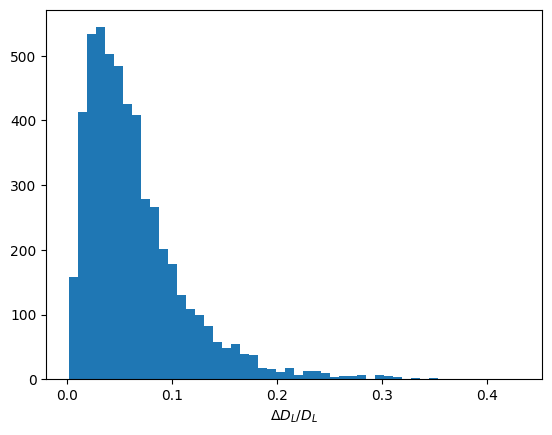

In [43]:
plt.hist(results_updated['errors']['luminosity_distance']/results_updated['all_inj_params_original']['distance'], bins=50);
plt.xlabel('$\Delta D_L / D_L$')

Text(0.5, 0, 'Network SNR')

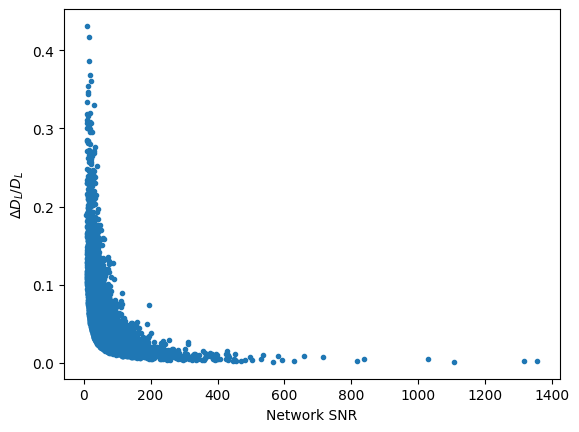

In [44]:
plt.plot(results_updated['netw_snrs'], 
         results_updated['errors']['luminosity_distance']/results_updated['all_inj_params_original']['distance'], '.')
plt.ylabel('$\Delta D_L / D_L$')
plt.xlabel('Network SNR')

### Check the recomibing has not messed up matrix orders

In [45]:
dl_idx = list(results_updated['errors'].keys()).index('luminosity_distance')
dl_idx

2

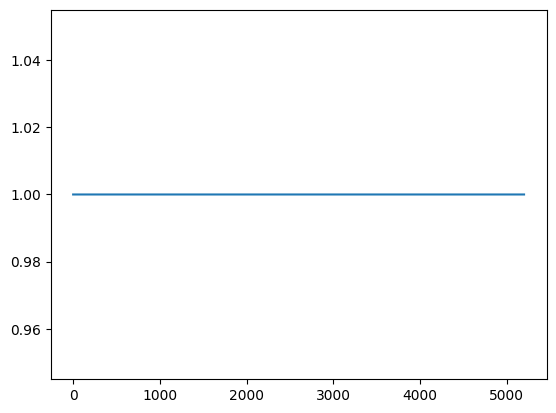

In [46]:
dl_errs_from_covs = [np.sqrt(cov[dl_idx, dl_idx]) for cov in results_updated['cov']]
plt.plot(results_updated['errors']['luminosity_distance']/dl_errs_from_covs)

### Check SNRs are matching with injected

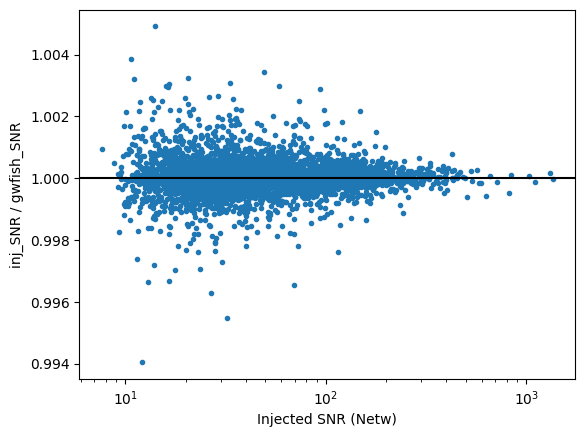

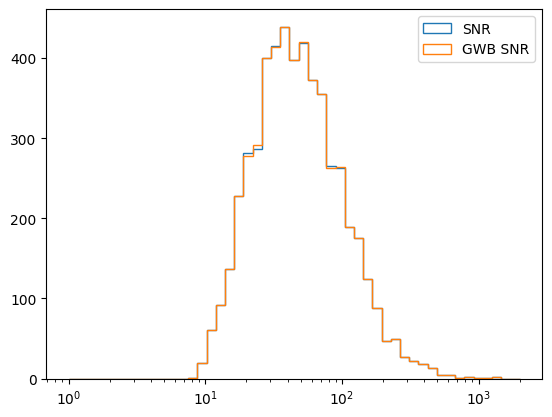

In [47]:
inj_snrs = results_updated['all_inj_params_original']['SNR_network']
gwfish_snrs = results_updated['netw_snrs']

plt.figure()
plt.plot(inj_snrs, inj_snrs/gwfish_snrs, '.')
plt.xlabel('Injected SNR (Netw)')
plt.ylabel('inj_SNR / gwfish_SNR')
plt.axhline(1, c='k')
plt.xscale('log')

plt.figure()
plt.hist(inj_snrs, bins=np.logspace(0,3.3,50), histtype=u'step', label='SNR');
plt.hist(gwfish_snrs, bins=np.logspace(0,3.3,50), histtype=u'step', label='GWB SNR');
plt.legend()
plt.xscale('log')

## Save to h5 file

In [48]:
def save_to_h5_group(group, data, string_dtype, key=None):
    # if key is given, create dataset/group under that name
    if isinstance(data, dict):
        subgroup = group if key is None else group.create_group(str(key))
        for k, v in data.items():
            save_to_h5_group(subgroup, v, string_dtype, k)

    elif isinstance(data, (list, tuple)):
        subgroup = group if key is None else group.create_group(str(key))
        for i, item in enumerate(data):
            save_to_h5_group(subgroup, item, string_dtype, str(i))

    elif isinstance(data, pd.DataFrame):
        subgroup = group if key is None else group.create_group(str(key))
        for col in data.columns:
            subgroup.create_dataset(str(col), data=data[col].to_numpy())

    elif isinstance(data, str):
        if key is None:
            raise ValueError("Strings must be stored with a key")
        group.create_dataset(str(key), data=data, dtype=string_dtype)

    else:
        if key is None:
            raise ValueError("Scalars/arrays must be stored with a key")
        group.create_dataset(str(key), data=np.array(data))


def save_results_to_h5(results, filename):
    dt = h5py.string_dtype(encoding='utf-8')
    with h5py.File(filename, 'w') as f:
        save_to_h5_group(f, results, dt)

### Write to file

In [49]:
print(results_updated.keys())
[type(results_updated[key]) for key in results_updated.keys()]

dict_keys(['netw_snrs', 'errors', 'sky_locs', 'all_inj_params_original', 'deriv_variables_in_order', 'inj_params', 'cov'])


[numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray]

In [50]:
results_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
                            f'CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_{len(results_updated["errors"])}_events_pop_from_XPHM_det10.h5')
#results_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
#                            f'LHI_Asharp_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_{len(results_updated["errors"])}_events_365_days_pop_from_XPHM_det10.h5')
results_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_5200_events_pop_from_XPHM_det10.h5'

In [51]:
save_results_to_h5(results_updated, results_file)

## Check that the file was saved properly

In [52]:
with h5py.File(results_file, 'r') as f:
    print(f.keys())
    print(f['errors'].keys())
    print(f['deriv_variables_in_order'][()])
    print(f['netw_snrs'][()])
    print(f['all_inj_params_original'].keys())

<KeysViewHDF5 ['all_inj_params_original', 'cov', 'deriv_variables_in_order', 'errors', 'inj_params', 'netw_snrs', 'sky_locs']>
<KeysViewHDF5 ['chirp_mass', 'dec', 'geocent_time', 'luminosity_distance', 'mass_ratio', 'phase', 'psi', 'ra', 'theta_jn']>
[b'chirp_mass' b'mass_ratio' b'luminosity_distance' b'theta_jn' b'phase'
 b'geocent_time' b'ra' b'dec' b'psi']
[52.48623881 14.76845756 34.19609247 ... 61.43622562 43.50593561
 75.69295526]
<KeysViewHDF5 ['PSD_C1', 'PSD_CE20', 'PSD_E1', 'PSD_E2', 'PSD_E3', 'SNR_C1', 'SNR_CE20', 'SNR_E1', 'SNR_E2', 'SNR_E3', 'SNR_mf_C1', 'SNR_mf_CE20', 'SNR_mf_E1', 'SNR_mf_E2', 'SNR_mf_E3', 'SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1', 'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network', 'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar', 'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final', 'f_lower', 'f_ref', 'inclinatio